# Generate Datasets using DC approximation for Power Grid usecase
This notebook allows to generate datasets for training and evaluation of augmented simulators using DC solver. In this case, the environment parameters should be modified to let the DC approximation be activate. Furthermore, we require to store the information concerning the admittance matrices via DC specific functions, that are implemented and integrated in various LIPS modules.

In [1]:
import pathlib

LIPS_PATH = pathlib.Path().resolve().parent.parent.parent
CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_neurips_2020_track1_small.ini"
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox" / "DC"
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_neurips_2020_track1_small" / "DC"
LOG_PATH = LIPS_PATH / "lips_logs.log"

In [2]:
if not DATA_PATH.exists():
    DATA_PATH.mkdir(mode=511, parents=False)

In [3]:
from lips.benchmark.powergridBenchmark import PowerGridBenchmark

benchmark5 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark4",
                                load_data_set=False,
                                config_path=CONFIG_PATH,
                                log_path=LOG_PATH)

/home/milad.leyli-abadi/.conda/envs/env-lips-irt/lib/python3.8/site-packages/grid2op/Backend/PandaPowerBackend.py:31: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/milad.leyli-abadi/.conda/envs/env-lips-irt/bin/python -m pip install numba

  warnings.warn(


In [4]:
benchmark5.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                    do_store_physics=True,
                    is_dc=True
                   )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.21it/s]


## Error and Solution illustration

In [ ]:
import re
import numpy as np
import grid2op
from grid2op.Parameters import Parameters
from lightsim2grid import LightSimBackend

In [ ]:
param = Parameters()
env_params = {
	"NO_OVERFLOW_DISCONNECTION": True,
	"MAX_LINE_STATUS_CHANGED": 999999,
	"MAX_SUB_CHANGED": 999999,
	"NB_TIMESTEP_COOLDOWN_LINE": 0,
	"NB_TIMESTEP_COOLDOWN_SUB": 0}
param.init_from_dict(env_params)
param.ENV_DC = True


env_seed = 1
initial_chronics_id = 864

# create the environment with specific parameters
env = grid2op.make("l2rpn_case14_sandbox", backend=LightSimBackend(), param=param)
env.seed(env_seed)
env.chronics_handler.set_filter(lambda path: re.match("^((?!(.*9[0-9][0-9].*)).)*$", path) is not None)
env.chronics_handler.real_data.reset()
env.set_id(initial_chronics_id)
obs = env.reset()

In [ ]:
# Make the action in question
topo_vect = np.array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
                       1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                       1,  1, -1,  2,  2,  2,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                       1,  1,  1,  1,  1,  1], dtype=int)
action_list = [(idx, el) for idx, el in enumerate(topo_vect)]

action = env.action_space({})
action.set_bus = action_list

In [ ]:
obs, reward, done, info = env.step(action)
print("DC topo_vect", obs.topo_vect)
assert done is False

DC topo_vect [ 1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  2  2  2  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1]


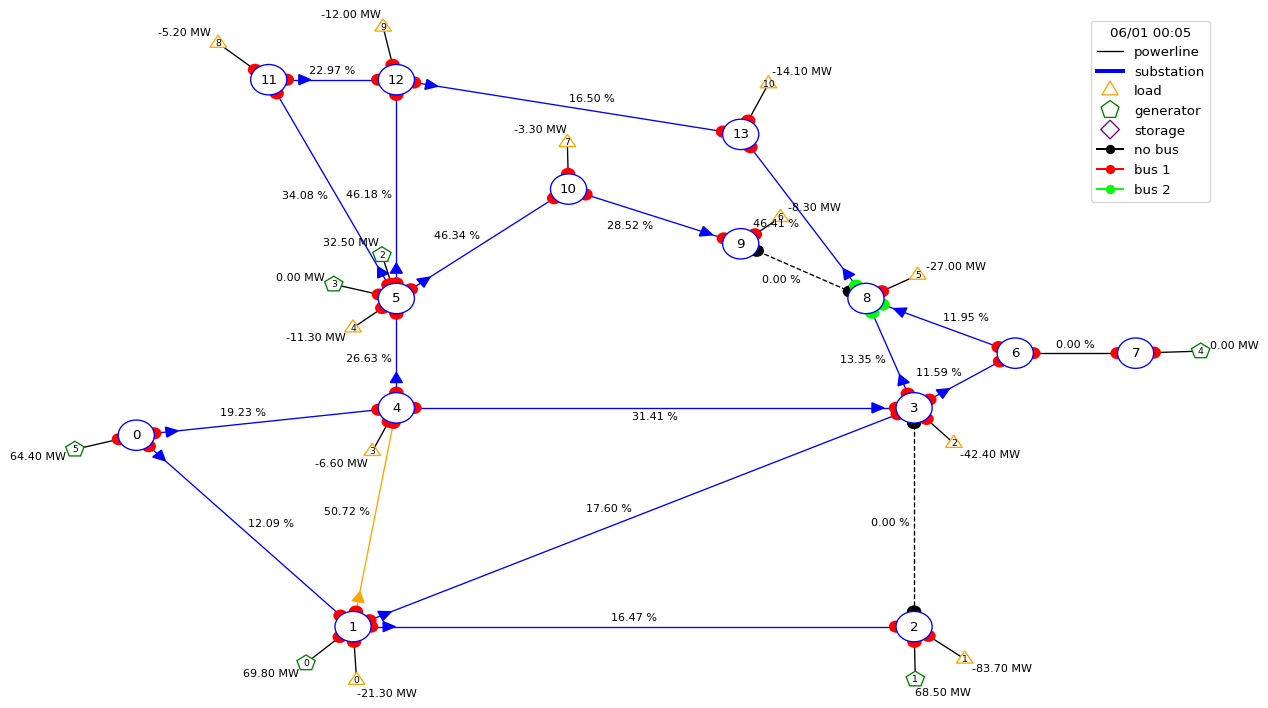

In [ ]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()

## Function allowing to find isolated injections

In [ ]:
def any_isolated_injections(obs):
    """Verifies if there are any isolated injections in current obs

    Parameters
    ----------
    obs : _type_
        the current observation for which this verification should be performed

    Returns
    -------
    ``bool``
        If `True` there are some isolated injections
    """
    check_list = []
    for sub_id in range(obs.n_sub):
        sub_obj = obs.get_obj_connect_to(substation_id=sub_id)
        gens = sub_obj["generators_id"]
        loads = sub_obj["loads_id"]
        if len(gens) < 1 and len(loads) < 1:
            continue
        lines_or = sub_obj["lines_or_id"]
        lines_ex = sub_obj["lines_ex_id"]
        lines_topo = []
        injections_topo = []
        if len(lines_or) > 0:
            for line_or in lines_or:
                line_pos = obs.line_or_pos_topo_vect[line_or]
                line_topo_vect = obs.topo_vect[line_pos]
                lines_topo.append(line_topo_vect)
        if len(lines_ex) > 0:
            for line_ex in lines_ex:
                line_pos = obs.line_ex_pos_topo_vect[line_ex]
                line_topo_vect = obs.topo_vect[line_pos]
                lines_topo.append(line_topo_vect)
        if len(loads) > 0:
            for load in loads:
                load_pos = obs.load_pos_topo_vect[load]
                load_topo_vect = obs.topo_vect[load_pos]
                injections_topo.append(load_topo_vect)
        if len(gens) > 0:
            for gen in gens:
                gen_pos = obs.gen_pos_topo_vect[gen]
                gen_topo_vect = obs.topo_vect[gen_pos]
                injections_topo.append(gen_topo_vect)

        check = any(item in lines_topo for item in injections_topo)
        if check is True:
            print("No isolated injection found")
        else:
            print(f"At least one isolated injection found at substation {sub_id}")
        check_list.append(check)
    
    check_all = not(all(check_list))
    if check_all:
        print("There are some isolated injections")
    return check_all
    

In [ ]:
any_isolated_injections(obs)

No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
At least one isolated injection found at substation 8
No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
No isolated injection found
There are some isolated injections


True

### Error in generation when a node is isolated

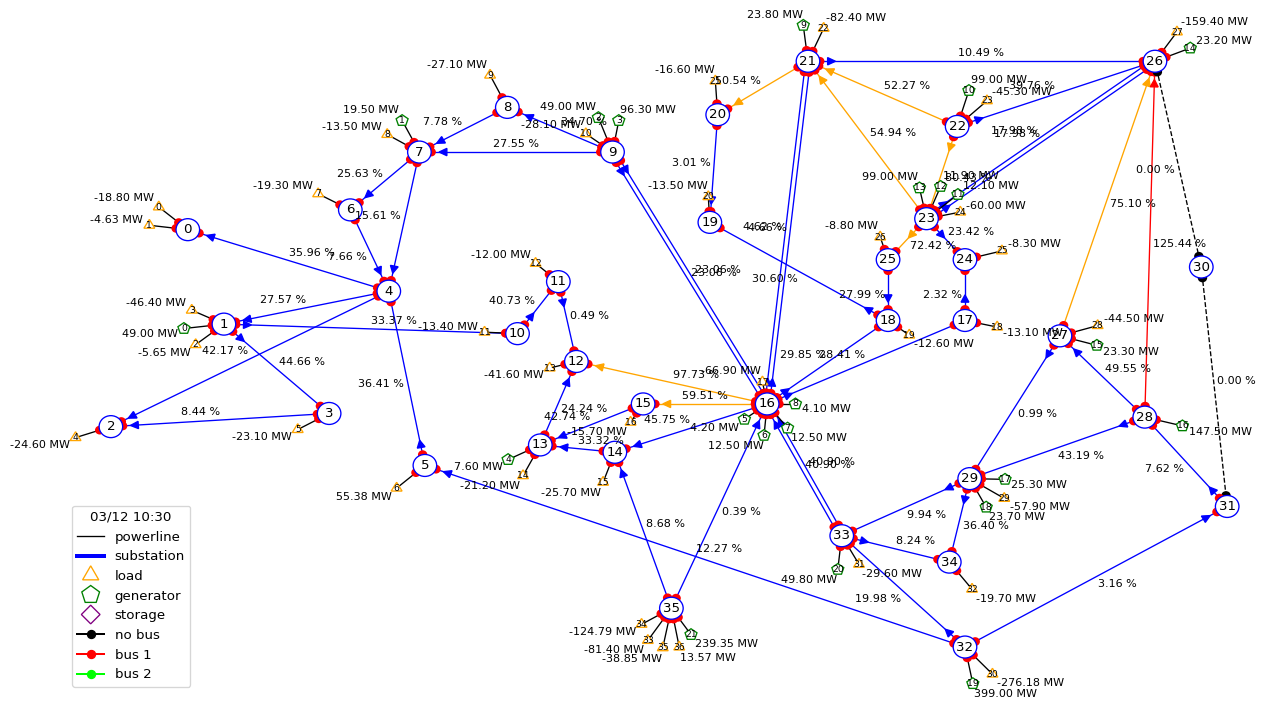

In [ ]:
from grid2op.PlotGrid import PlotMatplot

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()